### Phase fraction uncertainty quantification

For a given phase, define the normalized intensities as

$$Z_i = I_i / R_i$$

For now, we'll assume the $R_i$ are known completely while we figure out how to implement them efficiently in GSAS. (Either way this is likely a small component of uncertainty relative to the experimental variability of the $I_i$'s.)

There is uncertainty in the $I_i$'s both due to experimental set up as well as the fitting procedure. We'll assume these sources of uncertainty are independent, and thus additive. Thus we model

$$
I_i \sim N(\mu_I, \sigma_{I,exp}^2 + \sigma_{fit_i}^2)
$$

and so 

$$
Z_i \sim N\big(\mu_z, \sigma_{Z,exp}^2 + \frac{\sigma_{fit_i}^2}{R_i^{2}} \big)
$$

$\sigma^2_{fit_i}$ will be assumed known from the fitting procedure, while $\sigma^2_{Z,exp}$ will have to be estimated from data. Since we won't estimate $\mu_I$ and $\sigma^2_{I,exp}$ directly, we will simply denote $\mu_Z$ and $\sigma_Z$ as $\mu$ and $\sigma$ respectively.

In the Bayesian framework, we can write

\begin{align}
p(\mu, \sigma^2_{exp} | Z_i) &\propto p(Z_i|\mu, \sigma^2_{exp}) p(\mu, \sigma^2_{exp}) \\
&= N(Z_i,\mu,\sigma^2_{exp} + R_i^{-2}\sigma^2_{fit}) p(\mu,\sigma^2_{exp})
\end{align}

where the prior distributions will be a standard choice such as a truncated $t_4$ scaled to the MAD. 

Estimation for the other phases will follow similarly.

### Example

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
from scipy.stats import median_abs_deviation as mad
import plotly.express as px
import seanborn as sns


In [4]:
print(az.__version__)
print(pm.__version__)

0.11.2
3.6


In [103]:
indata = pd.read_csv('intensity_table.csv')

In [104]:
indata.head()

,Unnamed: 0,F_calc_sq,I_corr,Peak_Fit_Success,Phase,R_calc,back_int_bound,gam_fit,h,int_fit,...,pos_diff,pos_fit,rel_int_count,rel_int_fit,sig_fit,signal_to_noise,two_theta,u_int_count,u_int_fit,u_pos_fit
0,0,4521.730,57.756,True,austenite-SRM487.cif,261157.488,4570.369,1.714,1,21716.194,...,0.002,43.595,0.007,0.008,79.606,133.942,43.593,162.131,168.301,0.001
1,1,1162.762,162.151,True,ferrite-SRM487.cif,188543.096,4044.526,1.741,1,62590.189,...,-0.013,44.562,0.004,0.004,74.617,242.469,44.575,258.137,258.280,0.000
2,2,3832.366,31.933,True,austenite-SRM487.cif,122379.402,6611.231,1.920,2,7812.145,...,-0.038,50.738,0.015,0.016,146.225,65.048,50.777,120.097,123.253,0.003
3,3,754.402,39.325,True,ferrite-SRM487.cif,29667.204,4384.424,2.374,2,7283.611,...,-0.043,64.828,0.015,0.016,131.875,67.429,64.871,108.019,113.272,0.003
4,4,2211.653,31.901,True,austenite-SRM487.cif,70554.804,5163.941,2.740,2,4734.357,...,0.019,74.670,0.021,0.022,179.066,47.586,74.651,99.490,103.257,0.004


In [119]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R

In [123]:
print(mydf)

            I           R  sigma_I                phases   two_th        IR
0   21716.194  261157.488  168.301  austenite-SRM487.cif   43.593  0.083154
1   62590.189  188543.096  258.280    ferrite-SRM487.cif   44.575  0.331968
2    7812.145  122379.402  123.253  austenite-SRM487.cif   50.777  0.063835
3    7283.611   29667.204  113.272    ferrite-SRM487.cif   64.871  0.245511
4    4734.357   70554.804  103.257  austenite-SRM487.cif   74.651  0.067102
5   17954.038   58818.348  152.070    ferrite-SRM487.cif   82.127  0.305246
6    4864.974   80763.209  110.421  austenite-SRM487.cif   90.633  0.060238
7    1368.346   23555.357   80.239  austenite-SRM487.cif   95.910  0.058091
8    5211.789   19287.603   98.365    ferrite-SRM487.cif   98.667  0.270214
9    7830.424   32124.524  122.684    ferrite-SRM487.cif  116.249  0.243752
10     92.318   13186.997   47.393  austenite-SRM487.cif  118.074  0.007001


<AxesSubplot:xlabel='two_th', ylabel='IR'>

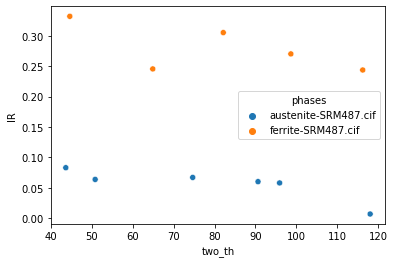

In [125]:
sns.scatterplot(data=mydf,x='two_th',y='IR',hue='phases')

In [140]:
def run_mcmc(I,R,sigma_I,phases,pfs,plot=False):

    I = np.array(I)[pfs]
    R = np.array(R)[pfs]
    sigma_I = np.array(sigma_I)[pfs]
    phases = np.array(phases)[pfs]


    phase_counts = np.unique(phases, return_counts=True)[1]

    if np.min(phase_counts) <= 2:
        return None

    phase_names = phases.copy()

    Z = I/R
    unique_phase_names = np.unique(phase_names)

    phases = np.zeros(len(phases),dtype=np.int8)
    
    # create numeric index for each phase
    for ii in range(len(unique_phase_names)):

        phases[phase_names==unique_phase_names[ii]] = int(ii)

    unique_phases = np.unique(phases)
    phase_stds = np.zeros(len(unique_phases))

    # standard deviations for each phase
    for ii in range(len(unique_phases)):

        phase_stds[ii] = np.std(Z[phases==unique_phases[ii]])

    # prior scale and means
    prior_scale=np.mean(phase_stds)
    prior_mean_centers = np.ones(len(unique_phases))

    #print(prior_scale)
    #print(prior_mean_centers)   

    if plot:
        plt.scatter(x=np.arange(len(Z)),y=Z,c=phases)
        print("Z: {}".format(Z))
        print("phases: {}".format(phases))

    basic_model = pm.Model() 

    with basic_model:
        
        # Priors for unknown model parameters
        sigma_exp = pm.HalfStudentT("sigma_exp", sd=prior_scale*2, nu=4,shape=len(unique_phases))
        mu = pm.TruncatedNormal("mu", 
                       mu=prior_mean_centers, 
                       sd=np.std(Z)*10,
                       lower=0,
                       shape=len(unique_phases))
        
        full_sigma = pm.math.sqrt( (1/R**2)*(sigma_I**2) + pm.math.sqr(sigma_exp[phases]) )

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu[phases], sd=full_sigma, observed=Z)

        #if plot:
            #pm.model_to_graphviz(basic_model)

        trace = pm.sample(1000, return_inferencedata=False,tune=1000)
        
        mu_norm = np.apply_along_axis(lambda x: x/np.sum(x),1,trace['mu'])
        
        mu_df = pd.DataFrame(mu_norm,columns=unique_phase_names)
        mu_df = pd.melt(mu_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')
        
        #sig_df = pd.DataFrame(trace['sigma_exp'],columns=unique_phase_names)
        #sig_df = pd.melt(sig_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')

    return {'mu_df':mu_df,'trace':trace,'unique_phase_names':unique_phase_names}

Z: [0.08315363 0.33196755 0.06383546 0.24551053 0.06710184 0.30524553
 0.0602375  0.05809065 0.27021445 0.24375222 0.00700068]
phases: [0 1 0 1 0 1 0 0 1 1 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_exp]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1423.96draws/s]
The acceptance probability does not match the target. It is 0.8819650491386064, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


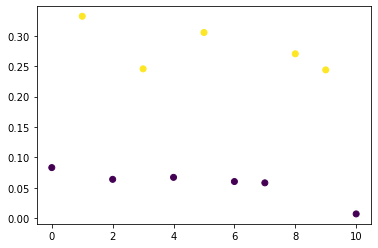

In [141]:
res = run_mcmc(mydf.I,mydf.R,mydf.sigma_I,mydf.phases,plot=True)

In [142]:
np.mean(res['trace']['mu'],axis=0)

array([0.05615651, 0.27975623])

In [149]:
dummy = np.unique([1,1,3],return_counts=True)

In [152]:
dummy[1]

array([2, 1], dtype=int64)

In [143]:
fig = px.histogram(res['mu_df'],x='value',color='which_phase',opacity=.7,barmode='overlay',histnorm='probability density')

In [144]:
fig

In [90]:
help(px.histogram)

Help on function histogram in module plotly.express._chart_types:

histogram(data_frame=None, x=None, y=None, color=None, pattern_shape=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, hover_name=None, hover_data=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, color_discrete_sequence=None, color_discrete_map=None, pattern_shape_sequence=None, pattern_shape_map=None, marginal=None, opacity=None, orientation=None, barmode='relative', barnorm=None, histnorm=None, log_x=False, log_y=False, range_x=None, range_y=None, histfunc=None, cumulative=None, nbins=None, title=None, template=None, width=None, height=None)
        In a histogram, rows of `data_frame` are grouped together into a
        rectangular mark to visualize the 1D distribution of an aggregate
        function `histfunc` (e.g. the count or sum) of the value `y` (or `x` if
        `orientation` is `'h'`).
        
    Parameters
    -----

In [ ]:
fig = ff.create_distplot(hist_data, group_labels)